In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (13, 10)

sns.set(style="whitegrid")

In [94]:
events_dtypes = {'event_id': 'category', 'ref_type': 'category', 'ref_hash': 'category',
                   'attributed': 'category', 'device_countrycode': 'category', 'device_os_version': 'category',
                   'device_brand' : 'category', 'device_model' : 'category', 'device_city': 'category', 'session_user_agent': 'category', 'user_agent': 'category', 'carrier': 'category',
                   'kind': 'category', 'device_os' : 'category', 'wifi': 'category', 'connection_type': 'category',
                   'device_language': 'category'}

In [95]:
events = pd.read_csv('events.csv', dtype = events_dtypes, low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

events["date_gmt"] = events['date'].dt.tz_localize("UTC").dt.tz_convert('America/Argentina/Cordoba').dt.tz_localize(None)
#En Argentina usamos GMT-3 al igual que en Uruguay

## ¿Cuáles son las aplicaciones que registraron mayor cantidad de eventos en ellas?

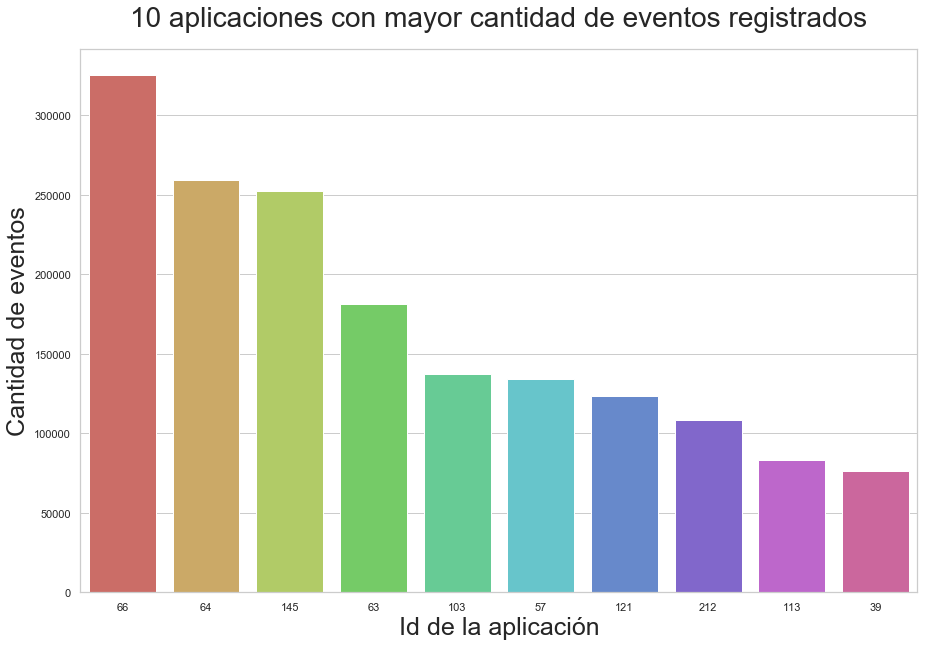

In [134]:
aplic_top_events = events.groupby('application_id').agg({'cant_eventos': 'count'})\
.sort_values(by = "cant_eventos", ascending = False).reset_index().head(10)

plt.rcParams["axes.labelsize"] = 30   
plot_d = sns.barplot(x=aplic_top_events['application_id'], y=aplic_top_events['cant_eventos'],\
order= [66, 64, 145, 63, 103, 57, 121, 212, 113, 39], orient='v',  palette="hls")
#plot_d.set_xticklabels(plot.get_xticklabels(),rotation=75)
plot_d.set_title("10 aplicaciones con mayor cantidad de eventos registrados", fontsize=28)
plot_d.set_xlabel("Id de la aplicación", fontsize=25)
plot_d.title.set_position([.5, 1.03])
plot_d.set_ylabel("Cantidad de eventos", fontsize=25)
plt.savefig("top_apps_events.jpeg", dpi = 300)

In [118]:
list(events['application_id'].value_counts().head(10).index)

[66, 64, 145, 63, 103, 57, 121, 212, 113, 39]

## ¿Cómo es la evolución -por hora- de los eventos realizados sobre las dos aplicaciones más utilizadas?

In [83]:
indices_aplicaciones_top = list(events['application_id'].value_counts().head(3).index)

In [84]:
indices_aplicaciones_top

['66', '64', '145']

In [85]:
eventos_por_hora = events.loc[events['application_id'].isin(indices_aplicaciones_top), ['date_gmt', 'application_id']]

In [86]:
eventos_por_hora['hora'] = eventos_por_hora['date_gmt'].dt.hour

In [87]:
eventos_por_hora['cant_eventos'] = 1
agrup_eventos_por_hora = eventos_por_hora.groupby(['hora','application_id']).agg({'cant_eventos': 'count'})

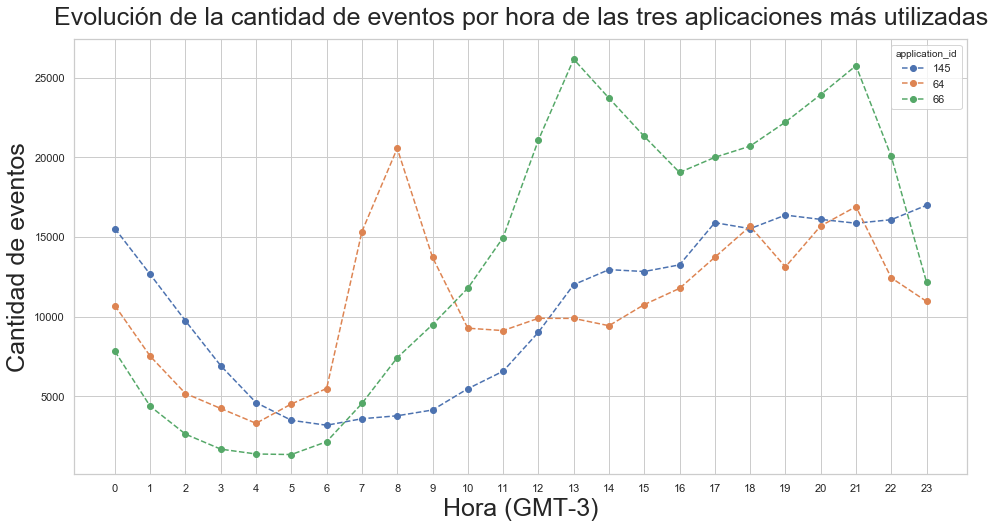

In [141]:
plot = agrup_eventos_por_hora.unstack().cant_eventos.plot(figsize = (16,8), linewidth = 1.5, style='o--')
plot.set_title('Evolución de la cantidad de eventos por hora de las tres aplicaciones más utilizadas', fontsize = 25)
plot.set_ylabel('Cantidad de eventos', fontsize = 25)
plot.set_xlabel('Hora (GMT-3)', fontsize = 25)
plot.title.set_position([.5, 1.02])
plot.xaxis.set_ticks(np.arange(0, 24, 1))
plt.savefig("Dos_aplic_mas_utilizadas_eventos.png", dpi = 300)

#### Con la visualización mostrada arriba, vimos un patrón que se repetía para las tres aplicaciones. A partir de las 0hs, disminuyó considerablemente la cantidad de eventos realizados sobre ellas. Decidimos profundizar sobre este tópico analizando la distribución por hora y día de los eventos.

## ¿Cómo se distribuyeron los eventos por hora y por día?

In [97]:
events['dia_de_la_semana'] = events['date_gmt'].dt.dayofweek
events['cant_eventos'] = 1
events['hora'] = events['date_gmt'].dt.hour

In [124]:
#week_events = events.drop(drop_index, axis = 0)
week_events = events.loc[(events['date_gmt'] >= pd.to_datetime("2019-03-05")) & (events['date_gmt'] < pd.to_datetime("2019-03-12"))]

In [125]:
group_events = week_events.groupby(['hora', 'dia_de_la_semana']).agg({'cant_eventos': 'count'})

In [126]:
group_events_unstacked = group_events.unstack()['cant_eventos'] 
group_events_unstacked = group_events_unstacked.fillna(0)

In [131]:
group_events_unstacked.columns = ['Lunes', 'Martes', 'Miércoles', 'Jueves','Viernes','Sábado', 'Domingo']

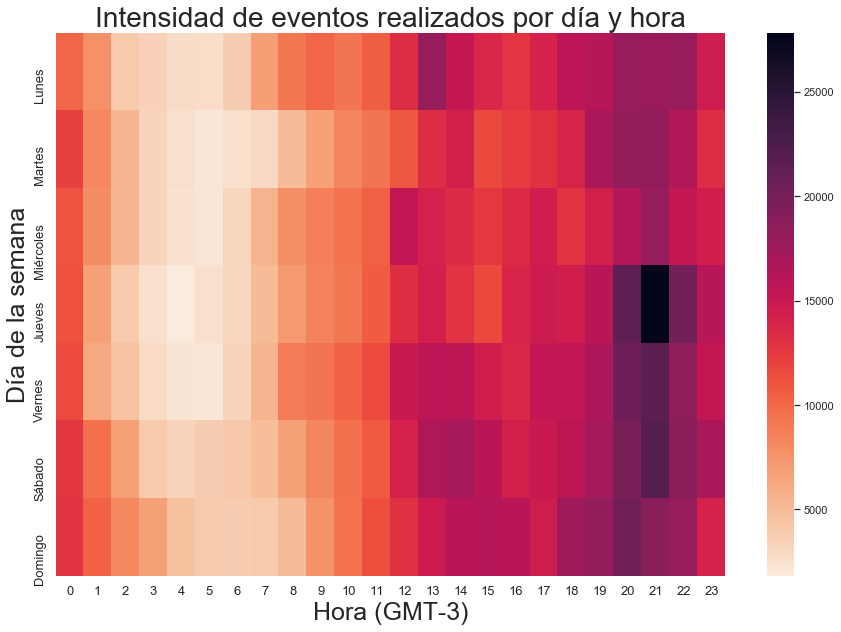

In [132]:
plt.rcParams['figure.figsize'] = (15, 10)

plot_b = sns.heatmap(group_events_unstacked.T, cmap = sns.cm.rocket_r)
plot_b.set_title("Intensidad de eventos realizados por día y hora", fontsize = 28)
plot_b.set_xlabel("Hora (GMT-3)", fontsize = 25)
plot_b.tick_params(labelsize=13, which='major')
plot_b.title.set_position([.5, 1.03])
plot_b.set_ylabel("Día de la semana", fontsize = 25)
plt.savefig("heatmap_events.png", dpi = 300)

### ¿Cuál es el porcentaje de eventos atribuidos a Jampp por hora?

In [64]:
eventos_atribuidos = events.loc[events['attributed'] == 'True']
group_eventos_atribuidos = eventos_atribuidos.groupby('hora').agg({'cant_eventos':'count'})

In [65]:
group_eventos = events.groupby('hora').agg({'cant_eventos':'count'})

In [67]:
group_eventos_atribuidos['porcentaje'] = (group_eventos_atribuidos['cant_eventos']*100/group_eventos['cant_eventos'])

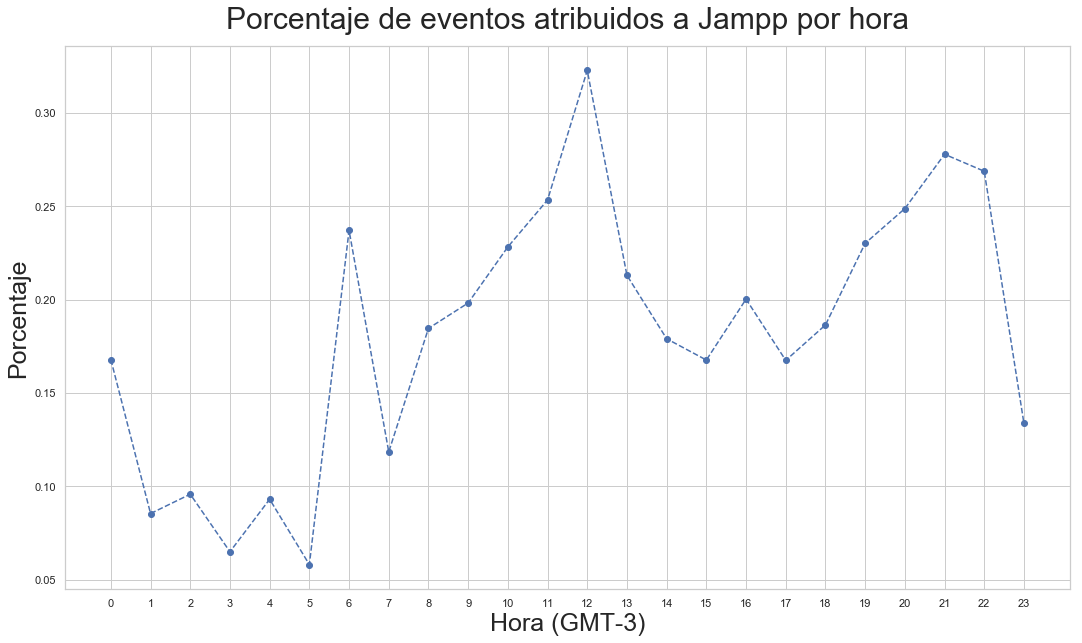

In [139]:
plot_c = group_eventos_atribuidos.drop(columns = ['cant_eventos']).plot(figsize = (18,10), legend = False, linewidth = 1.5, style='o--')
plot_c.set_ylabel("Porcentaje", fontsize = 25)
plot_c.set_title("Porcentaje de eventos atribuidos a Jampp por hora", fontsize = 30)
plot_c.title.set_position([.5, 1.02])
plot_c.set_xlabel("Hora (GMT-3)", fontsize = 25)
plot_c.xaxis.set_ticks(np.arange(0, 24, 1))
plt.savefig("percentaje_eventos_atribuidos.png", dpi = 300)